In [1]:
#import libraries
import pandas as pd
import numpy as np

In [2]:
#import dataset

log_files = pd.read_csv("./log2.csv", na_values = '?') 

In [3]:
log_files.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [4]:
log_files.shape

(65532, 12)

In [5]:
# Show missing values percentage for each column
missing_values = log_files.isnull().sum()
missing_percentage = (missing_values / log_files.shape[0]) * 100

# Create a dataframe to display the results
missing_summary = pd.DataFrame({"Missing Values": missing_values, "Percentage": missing_percentage})
missing_summary = missing_summary[missing_summary["Missing Values"] > 0].sort_values(by="Percentage", ascending=False)

missing_summary

,Missing Values,Percentage


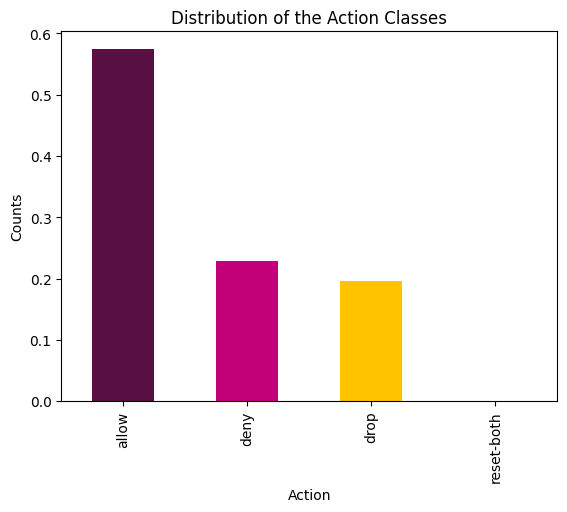

In [6]:
#look at the target classes
log_files['Action'].value_counts(normalize=True).plot(
    kind="bar",
    xlabel= "Action",
    ylabel="Counts",
    title="Distribution of the Action Classes",
    color=["#580F41", "#C20078", "#FFC300", "#00FFFF"]
);

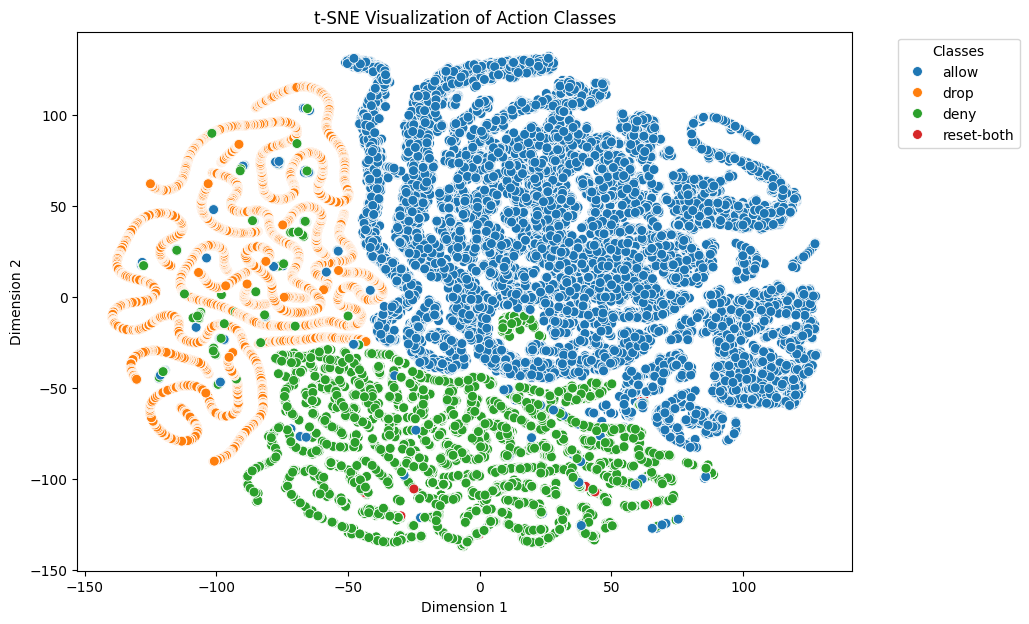

In [7]:
#t-SNE visualization of classes
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Separate features and labels
features = log_files.drop(columns=["Action"])  # Features only
classes = log_files['Action']  # Class 

#initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(features)

#create a dataFrame with t-SNE results and class labels
tsne_df = pd.DataFrame(X_tsne, columns=["Dimension 1", "Dimension 2"])
tsne_df['Action'] = classes.values

#plotting
plt.figure(figsize=(10, 7))
sns.scatterplot(data=tsne_df, x="Dimension 1", y="Dimension 2", hue="Action", palette="tab10", s=50)
plt.title("t-SNE Visualization of Action Classes")
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

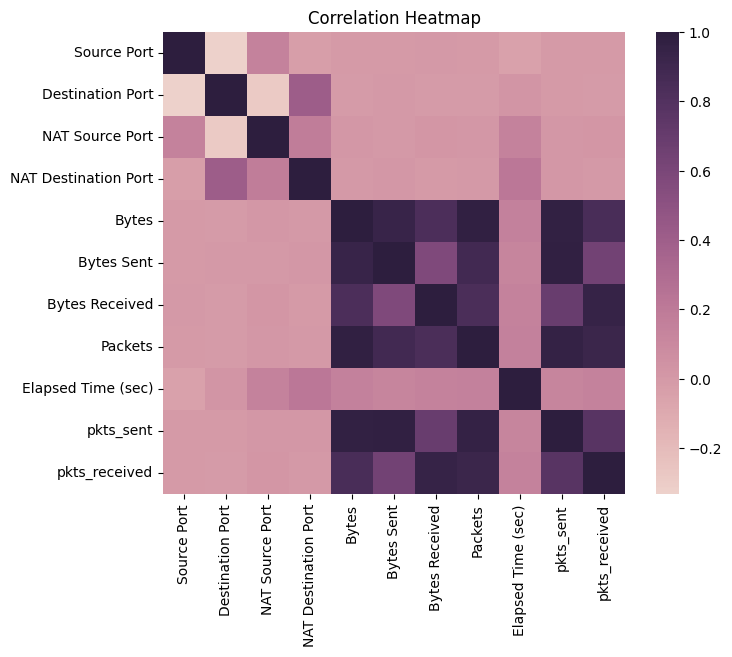

In [8]:
#correlation map of the features
corr_matrix = features.corr()

#plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap=sns.cubehelix_palette(as_cmap=True), square=True)
plt.title("Correlation Heatmap")
plt.show()

In [9]:
#Feature selection

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

X = log_files.drop(columns=["Action"])  
y = log_files['Action']

In [10]:
X.head(5)

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,177,94,83,2,30,1,1
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,25358,6778,18580,31,16,13,18


In [11]:
#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
#feature selection with Logistic Regression + Elastic Net
elastic_net_logreg = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=1.0, random_state=42)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling for Logistic Regression and SVC
    ('feature_selection', SelectFromModel(estimator=elastic_net_logreg, threshold='mean'))
])

In [13]:
#fit the pipeline to select features
pipeline.fit(X_train, y_train)

#get the mask of selected features
selected_feature_mask = pipeline.named_steps['feature_selection'].get_support()
selected_features = np.where(selected_feature_mask)[0]  # Get indices of selected features

print("Selected feature indices:", selected_features)
print("Selected features mask:", selected_feature_mask)

Selected feature indices: [0 1 2 3 8]
Selected features mask: [ True  True  True  True False False False False  True False False]


/Users/ericabrooks/anaconda3/envs/ML-7333/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [14]:
#transform data based on selected features
X_train_reduced = pipeline.transform(X_train)
X_test_reduced = pipeline.transform(X_test)

In [15]:
X_train_reduced.shape

(52425, 5)

In [16]:
X_test_reduced.shape

(13107, 5)

In [17]:
#SVC Linear

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

svm_model_linear = SVC(kernel='linear', decision_function_shape='ovr', probability=True, cache_size=200, random_state=42)
svm_model_linear.fit(X_train_reduced, y_train)
y_pred_linear = svm_model_linear.predict(X_test_reduced)

# Evaluation
print("SVM Linear Model Accuracy:", accuracy_score(y_test, y_pred_linear))
print("SVM Linear Model Classification Report:\n", classification_report(y_test, y_pred_linear))

SVM Linear Model Accuracy: 0.989394979781796
SVM Linear Model Classification Report:
               precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7545
        deny       0.99      0.96      0.98      2994
        drop       0.96      1.00      0.98      2562
  reset-both       0.00      0.00      0.00         6

    accuracy                           0.99     13107
   macro avg       0.74      0.74      0.74     13107
weighted avg       0.99      0.99      0.99     13107



/Users/ericabrooks/anaconda3/envs/ML-7333/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ericabrooks/anaconda3/envs/ML-7333/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ericabrooks/anaconda3/envs/ML-7333/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Confusion Matrix:
 [[7521   21    3    0]
 [   0 2885  109    0]
 [   0    0 2562    0]
 [   3    3    0    0]]


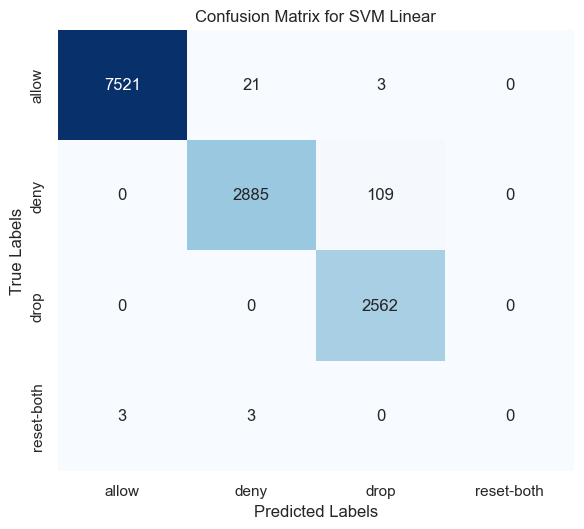

In [18]:
#generate confusion matrix
cm = confusion_matrix(y_test, y_pred_linear, labels=['allow', 'deny', 'drop', 'reset-both'])

print("Confusion Matrix:\n", cm)

# Optional: Plot the confusion matrix using a heatmap
plt.figure(figsize=(6, 6))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, xticklabels=['allow', 'deny', 'drop', 'reset-both'], yticklabels=['allow', 'deny', 'drop', 'reset-both'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels') 
plt.title('Confusion Matrix for SVM Linear')

plt.tight_layout() 
plt.subplots_adjust(bottom=0.2)
plt.show()

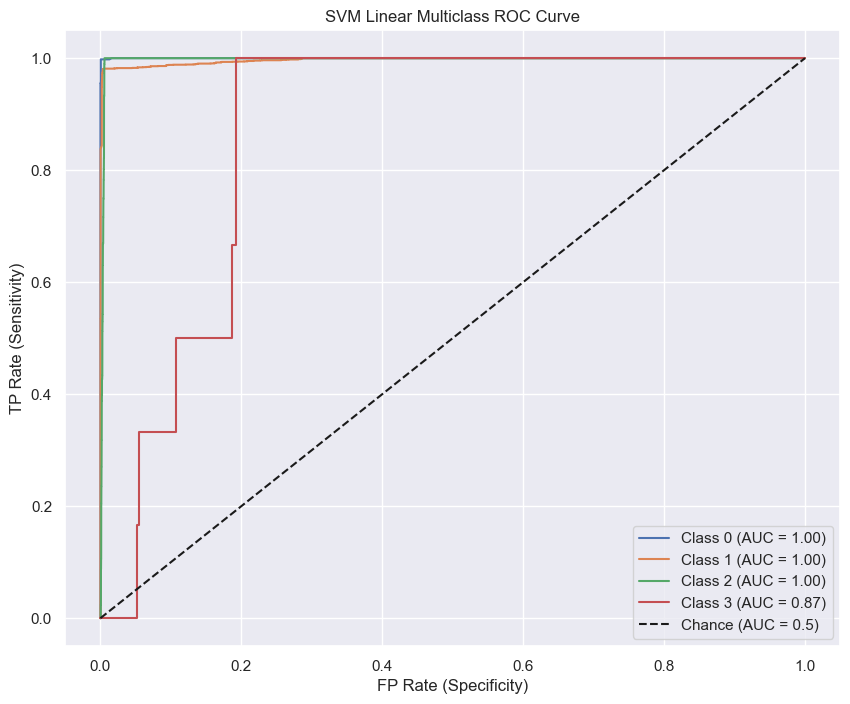

In [19]:
#AUC-ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC analysis
y_test_binarized = label_binarize(y_test, classes=["allow", "deny", "drop", "reset-both"])
n_classes = y_test_binarized.shape[1]

# Get prediction probabilities
y_score = svm_model_linear.predict_proba(X_test_reduced)

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')

# Labels and legend
plt.xlabel('FP Rate (Specificity)')
plt.ylabel('TP Rate (Sensitivity)')
plt.title('SVM Linear Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [20]:
#SVC RBF
svm_model_rbf = SVC(kernel='rbf', decision_function_shape='ovr', gamma='scale', probability=True, cache_size=200, random_state=42)
svm_model_rbf.fit(X_train_reduced, y_train)
y_pred_rbf = svm_model_rbf.predict(X_test_reduced)

# Evaluation
print("SVM RBF Model Accuracy:", accuracy_score(y_test, y_pred_rbf))
print("SVM RBF Model Classification Report:\n", classification_report(y_test, y_pred_rbf))

SVM RBF Model Accuracy: 0.98970016021973
SVM RBF Model Classification Report:
               precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7545
        deny       0.99      0.97      0.98      2994
        drop       0.96      1.00      0.98      2562
  reset-both       0.00      0.00      0.00         6

    accuracy                           0.99     13107
   macro avg       0.74      0.74      0.74     13107
weighted avg       0.99      0.99      0.99     13107



/Users/ericabrooks/anaconda3/envs/ML-7333/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ericabrooks/anaconda3/envs/ML-7333/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ericabrooks/anaconda3/envs/ML-7333/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Confusion Matrix:
 [[7512   30    3    0]
 [   0 2898   96    0]
 [   0    0 2562    0]
 [   3    3    0    0]]


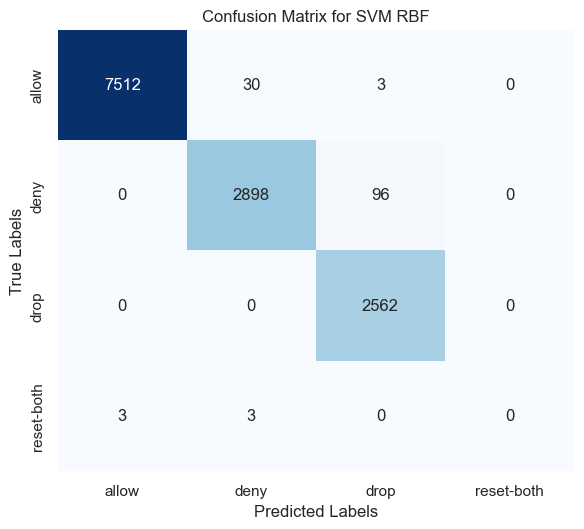

In [21]:
cm = confusion_matrix(y_test, y_pred_rbf, labels=['allow', 'deny', 'drop', 'reset-both'])

print("Confusion Matrix:\n", cm)

# Optional: Plot the confusion matrix using a heatmap
plt.figure(figsize=(6, 6))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, xticklabels=['allow', 'deny', 'drop', 'reset-both'], yticklabels=['allow', 'deny', 'drop', 'reset-both'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels') 
plt.title('Confusion Matrix for SVM RBF')

plt.tight_layout() 
plt.subplots_adjust(bottom=0.2)
plt.show()

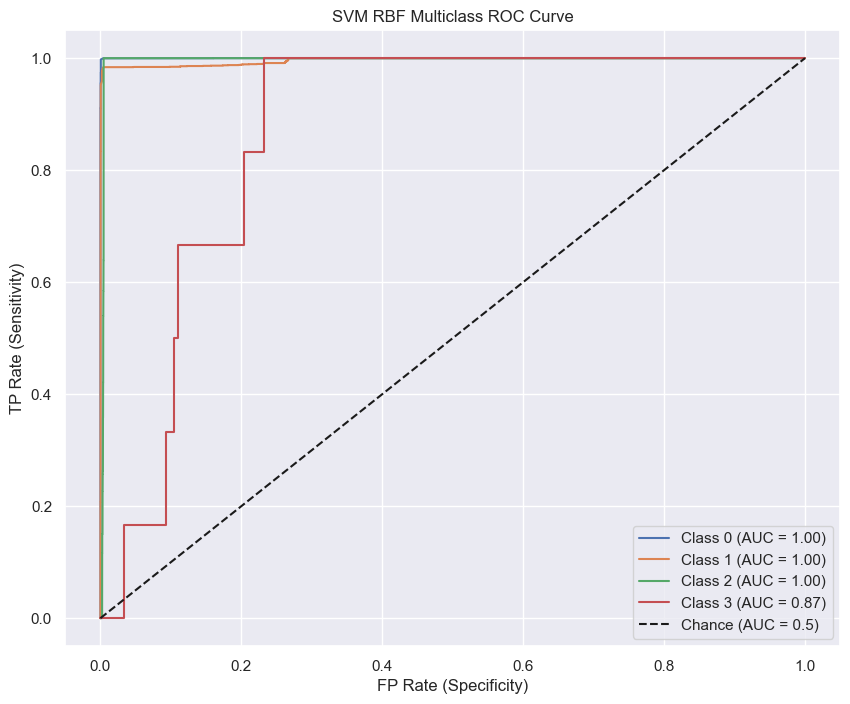

In [22]:
#AUC-ROC curve

# Get prediction probabilities
y_score_rbf = svm_model_rbf.predict_proba(X_test_reduced)

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score_rbf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')

# Labels and legend
plt.xlabel('FP Rate (Specificity)')
plt.ylabel('TP Rate (Sensitivity)')
plt.title('SVM RBF Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [23]:
#SVC Poly
svm_model_poly = SVC(kernel='poly', decision_function_shape='ovr', gamma='scale', degree=3, probability=True, cache_size=200, random_state=42)
svm_model_poly.fit(X_train_reduced, y_train)
y_pred_poly = svm_model_poly.predict(X_test_reduced)

# Evaluation
print("SVM Poly Model Accuracy:", accuracy_score(y_test, y_pred_poly))
print("SVM Poly Model Classification Report:\n", classification_report(y_test, y_pred_poly))

SVM Poly Model Accuracy: 0.9816128786144808
SVM Poly Model Classification Report:
               precision    recall  f1-score   support

       allow       1.00      0.98      0.99      7545
        deny       0.98      0.96      0.97      2994
        drop       0.93      1.00      0.96      2562
  reset-both       0.00      0.00      0.00         6

    accuracy                           0.98     13107
   macro avg       0.73      0.74      0.73     13107
weighted avg       0.98      0.98      0.98     13107



/Users/ericabrooks/anaconda3/envs/ML-7333/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ericabrooks/anaconda3/envs/ML-7333/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ericabrooks/anaconda3/envs/ML-7333/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Confusion Matrix:
 [[7426   41   78    0]
 [   0 2878  116    0]
 [   0    0 2562    0]
 [   3    3    0    0]]


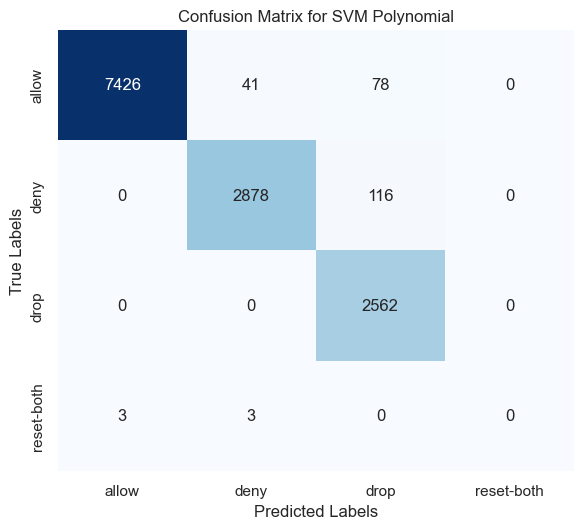

In [24]:
cm = confusion_matrix(y_test, y_pred_poly, labels=['allow', 'deny', 'drop', 'reset-both'])

print("Confusion Matrix:\n", cm)

# Optional: Plot the confusion matrix using a heatmap
plt.figure(figsize=(6, 6))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, xticklabels=['allow', 'deny', 'drop', 'reset-both'], yticklabels=['allow', 'deny', 'drop', 'reset-both'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels') 
plt.title('Confusion Matrix for SVM Polynomial')

plt.tight_layout() 
plt.subplots_adjust(bottom=0.2)
plt.show()

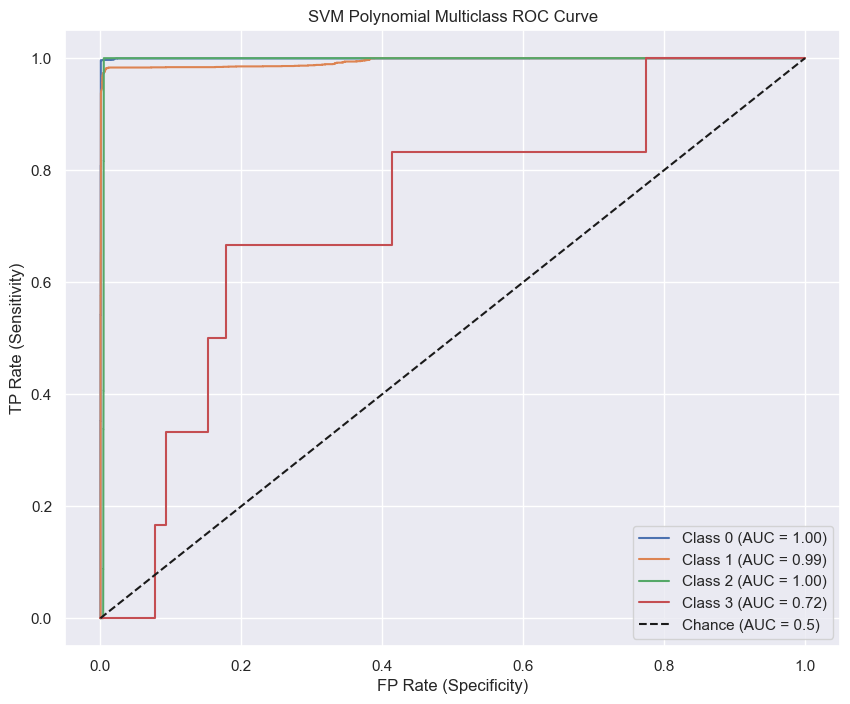

In [25]:
# Get prediction probabilities
y_score_poly = svm_model_poly.predict_proba(X_test_reduced)

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score_poly[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')

# Labels and legend
plt.xlabel('FP Rate (Specificity)')
plt.ylabel('TP Rate (Sensitivity)')
plt.title('SVM Polynomial Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [26]:
#SVC Sigmoid
svm_model_sig = SVC(kernel='sigmoid', decision_function_shape='ovr', gamma='scale', probability=True, cache_size=200, random_state=42)
svm_model_sig.fit(X_train_reduced, y_train)
y_pred_sig = svm_model_sig.predict(X_test_reduced)

# Evaluation
print("SVM Sig Model Accuracy:", accuracy_score(y_test, y_pred_sig))
print("SVM Sig Model Classification Report:\n", classification_report(y_test, y_pred_sig))

SVM Sig Model Accuracy: 0.833981841763943
SVM Sig Model Classification Report:
               precision    recall  f1-score   support

       allow       0.88      0.87      0.87      7545
        deny       0.80      0.77      0.79      2994
        drop       0.75      0.80      0.77      2562
  reset-both       0.00      0.00      0.00         6

    accuracy                           0.83     13107
   macro avg       0.61      0.61      0.61     13107
weighted avg       0.83      0.83      0.83     13107



/Users/ericabrooks/anaconda3/envs/ML-7333/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ericabrooks/anaconda3/envs/ML-7333/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ericabrooks/anaconda3/envs/ML-7333/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Confusion Matrix:
 [[6586  558  401    0]
 [ 403 2308  283    0]
 [ 525    0 2037    0]
 [   3    3    0    0]]


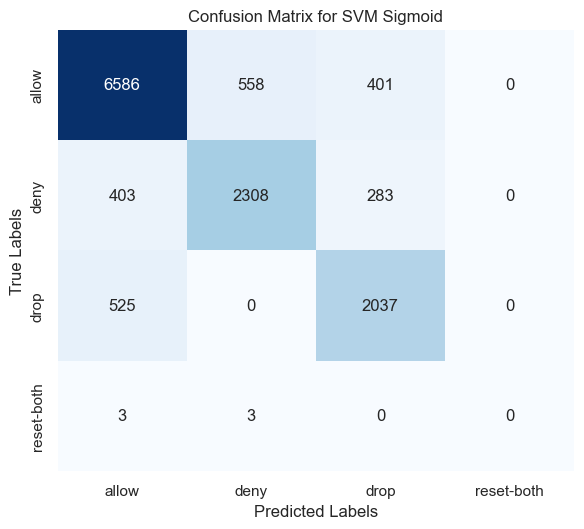

In [27]:
cm = confusion_matrix(y_test, y_pred_sig, labels=['allow', 'deny', 'drop', 'reset-both'])

print("Confusion Matrix:\n", cm)

# Optional: Plot the confusion matrix using a heatmap
plt.figure(figsize=(6, 6))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, xticklabels=['allow', 'deny', 'drop', 'reset-both'], yticklabels=['allow', 'deny', 'drop', 'reset-both'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels') 
plt.title('Confusion Matrix for SVM Sigmoid')

plt.tight_layout() 
plt.subplots_adjust(bottom=0.2)
plt.show()

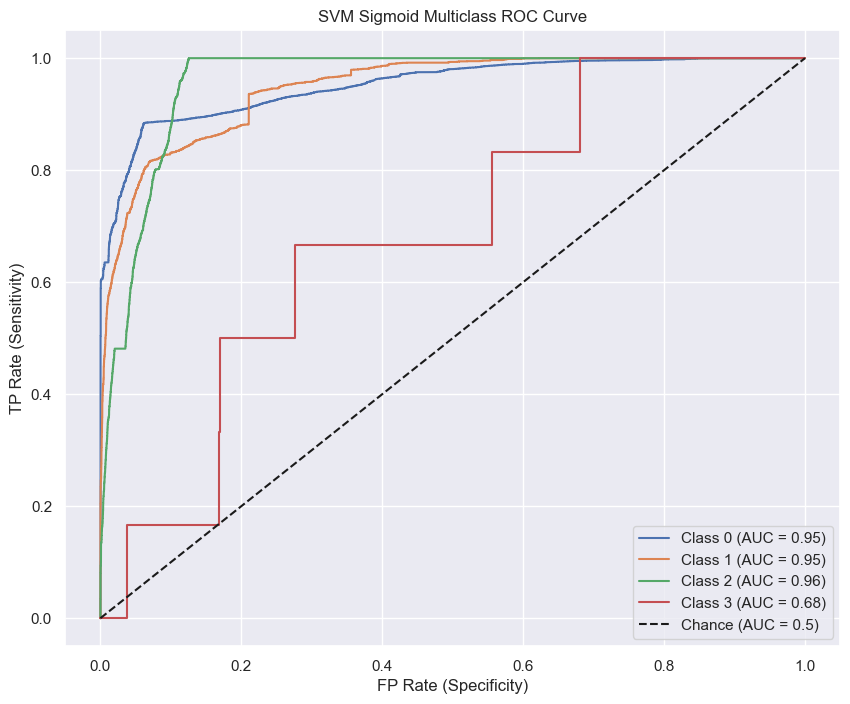

In [28]:
# Get prediction probabilities
y_score_sig = svm_model_sig.predict_proba(X_test_reduced)

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score_sig[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')

# Labels and legend
plt.xlabel('FP Rate (Specificity)')
plt.ylabel('TP Rate (Sensitivity)')
plt.title('SVM Sigmoid Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [29]:
# SGD Model
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, early_stopping=True, validation_fraction=0.1, n_iter_no_change=5, random_state=42)
sgd_model.fit(X_train, y_train)
y_pred_sgd = sgd_model.predict(X_test)

# Evaluation
print("SGD Model Accuracy:", accuracy_score(y_test, y_pred_sgd))
print("SGD Model Classification Report:\n", classification_report(y_test, y_pred_sgd))

SGD Model Accuracy: 0.9777218280308232
SGD Model Classification Report:
               precision    recall  f1-score   support

       allow       0.99      0.99      0.99      7545
        deny       0.99      0.93      0.96      2994
        drop       0.92      1.00      0.96      2562
  reset-both       0.00      0.00      0.00         6

    accuracy                           0.98     13107
   macro avg       0.73      0.73      0.73     13107
weighted avg       0.98      0.98      0.98     13107



/Users/ericabrooks/anaconda3/envs/ML-7333/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ericabrooks/anaconda3/envs/ML-7333/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ericabrooks/anaconda3/envs/ML-7333/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Confusion Matrix:
 [[7464   19   62    0]
 [  36 2789  169    0]
 [   0    0 2562    0]
 [   3    3    0    0]]


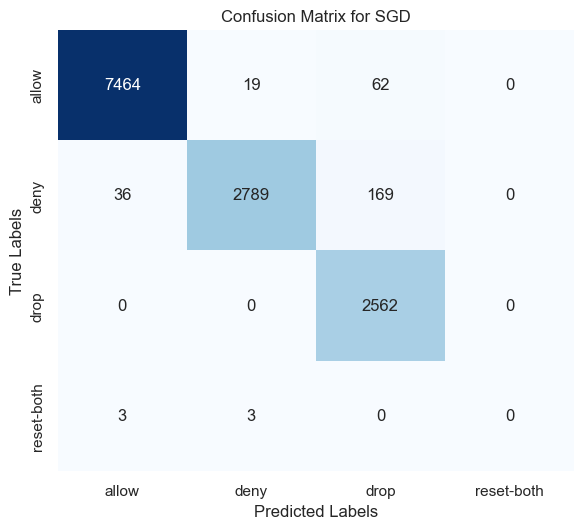

In [30]:
cm = confusion_matrix(y_test, y_pred_sgd, labels=['allow', 'deny', 'drop', 'reset-both'])

print("Confusion Matrix:\n", cm)

# Optional: Plot the confusion matrix using a heatmap
plt.figure(figsize=(6, 6))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, xticklabels=['allow', 'deny', 'drop', 'reset-both'], yticklabels=['allow', 'deny', 'drop', 'reset-both'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels') 
plt.title('Confusion Matrix for SGD')

plt.tight_layout() 
plt.subplots_adjust(bottom=0.2)
plt.show()

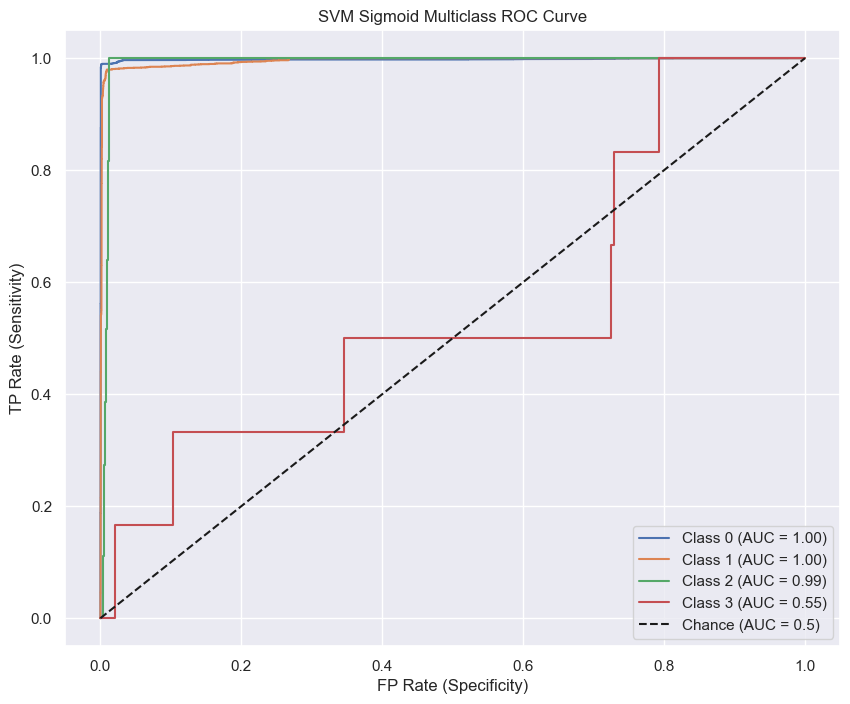

In [33]:
# Get prediction probabilities
y_score_sgd = sgd_model.decision_function(X_test)

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score_sgd[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')

# Labels and legend
plt.xlabel('FP Rate (Specificity)')
plt.ylabel('TP Rate (Sensitivity)')
plt.title('SVM Sigmoid Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()